In [1]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from skopt import BayesSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

In [2]:
features_df = pd.read_csv('~/Dokumente/Uni/Softwarepraktikum/Softwarepraktikum/features/ctd_cadiovascular_20240223_scores.tsv', sep='\t')
ground_truth_df = pd.read_csv('~/Dokumente/Uni/Softwarepraktikum/Softwarepraktikum/merged_cardio.tsv', sep='\t')

print(features_df)
print(ground_truth_df)

           drugA    drugB     sAB  opAB  meanspAB  medianspAB  minspAB  \
0        DB06709  DB08506  0.3427     0    0.6150       0.630     0.46   
1        DB06709  DB02376  0.4188     0    0.6850       0.685     0.56   
2        DB06709  DB04282  0.4188     0    0.6850       0.685     0.56   
3        DB06709  DB04564  0.4188     0    0.6850       0.685     0.56   
4        DB06709  DB04659  0.4188     0    0.6850       0.685     0.56   
...          ...      ...     ...   ...       ...         ...      ...   
9730661  DB08873  DB07191  0.1295     0    0.6093       0.625     0.44   
9730662  DB08873  DB08846  0.1319     0    0.4865       0.460     0.20   
9730663  DB08873  DB08865  0.1585     0    0.4858       0.480     0.26   
9730664  DB08873  DB05891  0.1004     0    0.8725       0.870     0.65   
9730665  DB08873  DB05508  0.2084     0    0.5350       0.530     0.41   

         maxspAB    zTDA    zTDB  ...  opAD  opBD  meanspAD  meanspBD  \
0           0.74  0.5076  1.2273  ... 

In [3]:
merged_df = pd.merge(features_df, ground_truth_df, on=['drugA', 'drugB'])
merged_df.set_index(['drugA', 'drugB'], inplace=True)
print(merged_df)

                    sAB  opAB  meanspAB  medianspAB  minspAB  maxspAB    zTDA  \
drugA   drugB                                                                   
DB00001 DB01626  0.5883     0    0.6450       0.645     0.64     0.65 -1.0344   
DB00006 DB01626  0.5883     0    0.6450       0.645     0.64     0.65 -1.0344   
DB00278 DB01626  0.5883     0    0.6450       0.645     0.64     0.65 -1.0344   
DB06695 DB08932  0.2533     0    0.4450       0.445     0.38     0.51 -1.0344   
DB00393 DB01116  0.6340     0    0.7717       0.775     0.58     0.95 -2.3273   
...                 ...   ...       ...         ...      ...      ...     ...   
DB08899 DB08932  0.1233     0    0.3000       0.300     0.28     0.32 -1.1392   
DB08905 DB08932  0.3833     0    0.5550       0.555     0.55     0.56  0.2616   
DB08918 DB08932  0.1547     0    0.5200       0.520     0.41     0.61 -2.0288   
DB08932 DB08953  0.3467     0    0.5200       0.520     0.51     0.53 -0.3467   
        DB08954  0.0550     

In [4]:
X = merged_df.drop(['adv/app','drugcomb','sA','sB','opA','opB'], axis=1)
# Annahme: 'adv/app' ist Ihre Zielvariable
Y = merged_df['adv/app']
print(Y)
print(X)

drugA    drugB  
DB00001  DB01626    1
DB00006  DB01626    1
DB00278  DB01626    1
DB06695  DB08932    1
DB00393  DB01116    1
                   ..
DB08899  DB08932    1
DB08905  DB08932    1
DB08918  DB08932    1
DB08932  DB08953    1
         DB08954    1
Name: adv/app, Length: 6935, dtype: int64
                    sAB  opAB  meanspAB  medianspAB  minspAB  maxspAB    zTDA  \
drugA   drugB                                                                   
DB00001 DB01626  0.5883     0    0.6450       0.645     0.64     0.65 -1.0344   
DB00006 DB01626  0.5883     0    0.6450       0.645     0.64     0.65 -1.0344   
DB00278 DB01626  0.5883     0    0.6450       0.645     0.64     0.65 -1.0344   
DB06695 DB08932  0.2533     0    0.4450       0.445     0.38     0.51 -1.0344   
DB00393 DB01116  0.6340     0    0.7717       0.775     0.58     0.95 -2.3273   
...                 ...   ...       ...         ...      ...      ...     ...   
DB08899 DB08932  0.1233     0    0.3000       0.300

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [6]:
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Definieren des Suchraums für Hyperparameter
param_space = {'C': (0.001, 100.0), 'penalty': ['l1', 'l2']}

# Initialisierung des logistischen Regressionsmodells
log_reg = LogisticRegression(solver='liblinear',max_iter=10000)

# Bayesian Optimization für die Hyperparameter-Optimierung
opt = BayesSearchCV(log_reg, param_space, cv=5, n_iter=20, random_state=42)
opt.fit(X_train_resampled, Y_train_resampled)

# Beste Hyperparameter nach der Bayesian Optimization
best_params = opt.best_params_

# Verwenden der besten Modellkonfiguration für Vorhersagen auf den Testdaten
best_model = opt.best_estimator_
predictions = best_model.predict(X_test)

# Bewertung der Vorhersagegenauigkeit
accuracy = accuracy_score(Y_test, predictions)
print("Vorhersagegenauigkeit der logistischen Regression:", accuracy)

# Classification report
report = classification_report(Y_test, predictions)
print("Classification Report:")
print(report)
#0.9920692141312184

KeyboardInterrupt: 

In [10]:
comparison = pd.DataFrame({'Actual': Y_test, 'Predicted': predictions})
#print(comparison.head(20))
#specific_drug_combination = ('DB01599', 'DB04825')
# Create a boolean mask where 'Actual' and 'Predicted' values are not equal
mask = comparison['Actual'] != comparison['Predicted']

# Apply this mask to your DataFrame to filter rows
differences = comparison[mask]

#28 falsch predicted
print(differences)
print(len(differences))

print("Accuracy:", accuracy_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions, labels=[0,1]))

                 Actual  Predicted
drugA   drugB                     
DB00500 DB00968       1          0
DB00533 DB00968       1          0
DB00559 DB01115       1          0
DB00384 DB01275       1          0
DB00783 DB00472       1          0
...                 ...        ...
DB00749 DB00968       1          0
DB00246 DB00412       1          0
DB01029 DB01119       1          0
DB00350 DB00903       1          0
DB00521 DB01119       1          0

[249 rows x 2 columns]
249
Accuracy: 0.8204758471521268
[[  10    1]
 [ 248 1128]]


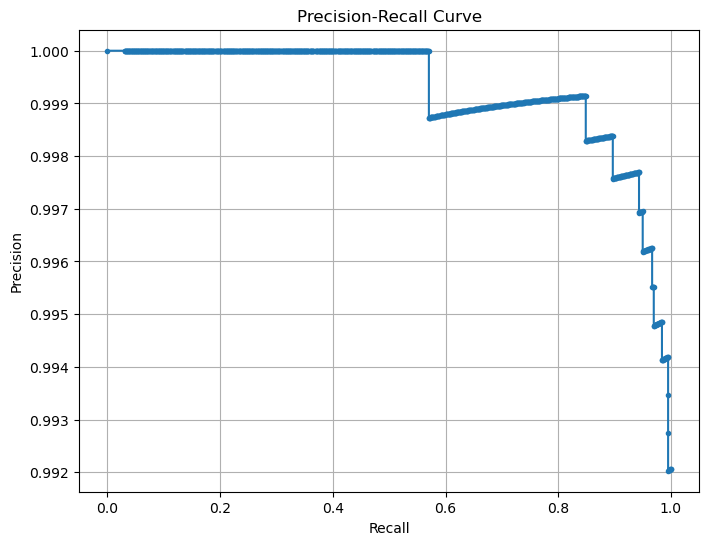

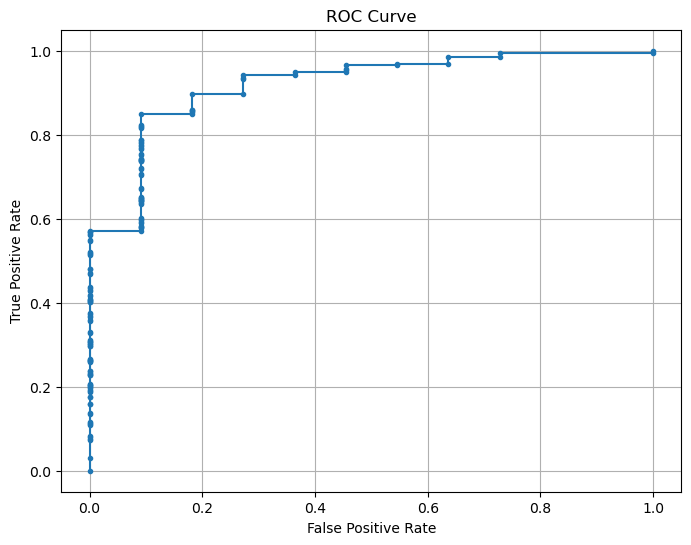

ROC AUC: 0.9194635306553912
Matthews Correlation Coefficient: 0.16614675736071513
Weighted F1 Score: 0.8940459956467047


In [11]:
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, roc_auc_score, matthews_corrcoef, f1_score
import matplotlib.pyplot as plt

# Predict probabilities for positive class
y_pred_probs = best_model.predict_proba(X_test)[:, 1]
# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(Y_test, y_pred_probs)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(Y_test, y_pred_probs)

# Calculate ROC AUC score
roc_auc = roc_auc_score(Y_test, y_pred_probs)

# Calculate Matthews correlation coefficient
mcc = matthews_corrcoef(Y_test,predictions)

# Calculate weighted F1 score
weighted_f1 = f1_score(Y_test, predictions, average='weighted')

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

# Print ROC AUC score
print(f'ROC AUC: {roc_auc}')

# Print Matthews correlation coefficient
print(f'Matthews Correlation Coefficient: {mcc}')

# Print weighted F1 score
print(f'Weighted F1 Score: {weighted_f1}')
